In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import plotly.express as px
import os
import math
from pandas.tseries.offsets import DateOffset

In [6]:
# 
# state_results = pd.read_csv('data_tables/state_results.csv')
state_results = pd.read_csv('data_tables/state_results.csv')
states = pd.read_csv('data_tables/states.csv')
state_results['Release Period'] = pd.to_datetime(state_results['Release Period'].str.lstrip('07_'))
state_results.columns = state_results.columns.str.lower().str.replace(' ', '_')
states.columns = states.columns.str.lower().str.replace(' ', '_')

state_results = state_results.merge(states, on='state', how='left')
state_results.head()

# Interpolate missing MD 2016 data
# New dataframes for MD 2015 and 2017 data
df = state_results.copy()
md_2015 = df[(df.state == 'MD') & (df.release_period == '2015-01-01')]
md_2017 = df[(df.state == 'MD') & (df.release_period == '2017-01-01')]

# Interpolate 2016 data using average of 2015 and 2017 data
md_inter = md_2015.copy()
for col in ['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage']:
    md_inter[col] = (md_2015[col].values + md_2017[col].values) / 2
md_inter['release_period'] = md_inter['release_period'] + DateOffset(years=1)

# Concatenate interpolated data with original dataframe
state_results = pd.concat([state_results, md_inter], ignore_index=True)
state_results

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage,state_name,region
0,2015-01-01,AK,H_CLEAN_HSP,8.0,22.0,70.0,Alaska,Pacific
1,2015-01-01,AK,H_COMP_1,9.0,17.0,74.0,Alaska,Pacific
2,2015-01-01,AK,H_COMP_2,10.0,15.0,75.0,Alaska,Pacific
3,2015-01-01,AK,H_COMP_3,11.0,21.0,68.0,Alaska,Pacific
4,2015-01-01,AK,H_COMP_5,19.0,17.0,64.0,Alaska,Pacific
...,...,...,...,...,...,...,...,...
4585,2016-01-01,MD,H_COMP_6,14.0,0.0,86.0,Maryland,South Atlantic
4586,2016-01-01,MD,H_COMP_7,7.0,45.0,48.0,Maryland,South Atlantic
4587,2016-01-01,MD,H_HSP_RATING,10.0,25.0,65.0,Maryland,South Atlantic
4588,2016-01-01,MD,H_QUIET_HSP,12.0,30.5,57.5,Maryland,South Atlantic


In [19]:
state_results['release_period'] = state_results['release_period'].dt.year
pre = state_results[state_results['release_period'] <= 2021].reset_index(drop=True)
pre['nps'] = pre['top-box_percentage'] - pre['bottom-box_percentage']
post = state_results[state_results['release_period'] >= 2021].reset_index(drop=True)
post['nps'] = post['top-box_percentage'] - post['bottom-box_percentage']


AttributeError: Can only use .dt accessor with datetimelike values

In [13]:
pre = pre[pre['measure_id'] == 'H_RECMND']

In [15]:
pre

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage,state_name,region,nps
9,2015,AK,H_RECMND,7.0,23.0,70.0,Alaska,Pacific,63.0
19,2015,AL,H_RECMND,5.0,24.0,71.0,Alabama,East South Central,66.0
29,2015,AR,H_RECMND,5.0,27.0,68.0,Arkansas,West South Central,63.0
39,2015,AZ,H_RECMND,6.0,24.0,70.0,Arizona,Mountain,64.0
49,2015,CA,H_RECMND,6.0,24.0,70.0,California,Pacific,64.0
...,...,...,...,...,...,...,...,...,...
3529,2021,WA,H_RECMND,4.0,23.0,73.0,Washington,Pacific,69.0
3539,2021,WI,H_RECMND,3.0,21.0,76.0,Wisconsin,East North Central,73.0
3549,2021,WV,H_RECMND,5.0,26.0,69.0,West Virginia,South Atlantic,64.0
3559,2021,WY,H_RECMND,3.0,27.0,70.0,Wyoming,Mountain,67.0


In [18]:
pre_nps = pre.groupby(['state', 'state_name', 'region'])['nps'].mean().reset_index()
pre_nps.sort_values('nps', ascending=False).head(10)

,state,state_name,region,nps
41,SD,South Dakota,West North Central,76.142857
29,NE,Nebraska,West North Central,76.000000
16,KS,Kansas,West North Central,74.142857
44,UT,Utah,Mountain,73.142857
23,MN,Minnesota,West North Central,73.000000
48,WI,Wisconsin,East North Central,72.714286
12,IA,Iowa,West North Central,72.714286
18,LA,Louisiana,West South Central,72.000000
21,ME,Maine,New England,71.857143
13,ID,Idaho,Mountain,71.857143


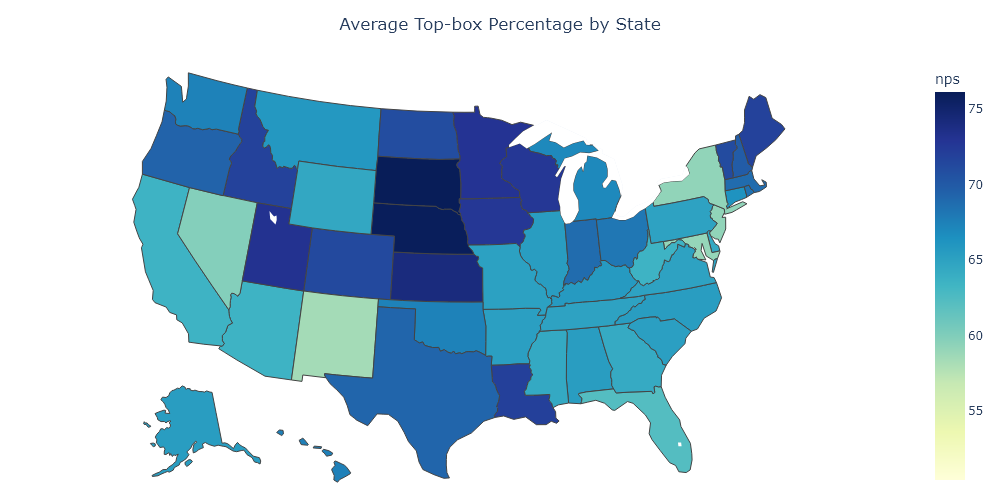

In [16]:
# Plot average top-box percentage by state
fig = px.choropleth(pre_nps, 
                    color='nps', 
                    locations='state', 
                    locationmode='USA-states', 
                    scope='usa',
                    color_continuous_scale='YlGnBu',
                    width=1000,
                    height=500)
fig.update_layout(title_text='Average Top-box Percentage by State', title_x=0.5, margin={"r":10,"t":60,"l":10,"b":10})



fig.show(renderer='png')

In [9]:
pre2 = pre.

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage,state_name,region,nps
0,2015,AK,H_CLEAN_HSP,8.0,22.0,70.0,Alaska,Pacific,62.0
1,2015,AK,H_COMP_1,9.0,17.0,74.0,Alaska,Pacific,65.0
2,2015,AK,H_COMP_2,10.0,15.0,75.0,Alaska,Pacific,65.0
3,2015,AK,H_COMP_3,11.0,21.0,68.0,Alaska,Pacific,57.0
4,2015,AK,H_COMP_5,19.0,17.0,64.0,Alaska,Pacific,45.0
...,...,...,...,...,...,...,...,...,...
3565,2016,MD,H_COMP_6,14.0,0.0,86.0,Maryland,South Atlantic,72.0
3566,2016,MD,H_COMP_7,7.0,45.0,48.0,Maryland,South Atlantic,41.0
3567,2016,MD,H_HSP_RATING,10.0,25.0,65.0,Maryland,South Atlantic,55.0
3568,2016,MD,H_QUIET_HSP,12.0,30.5,57.5,Maryland,South Atlantic,45.5


In [11]:
pre.groupby(['state', 'measure_id'])[['top-box_percentage']].mean()

top-box_percentage
state measure_id                      
AK    H_CLEAN_HSP            72.000000
      H_COMP_1               77.714286
      H_COMP_2               80.000000
      H_COMP_3               71.857143
      H_COMP_5               64.857143
...                                ...
WY    H_COMP_6               87.857143
      H_COMP_7               54.000000
      H_HSP_RATING           70.428571
      H_QUIET_HSP            62.714286
      H_RECMND               68.571429

[510 rows x 1 columns]